In [1]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=69bd75e0f0986914506845525271beaecf662a42481bb6c537436e831a99a0c6
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import pandas as pd
import re
from transformers import BertTokenizer, BertForTokenClassification, AdamW, BertTokenizerFast
from nltk.tokenize import sent_tokenize, word_tokenize
import torch.nn as nn
import torch
import tqdm

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words (you can add more if needed)
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_excel("/kaggle/input/miimansa/G1.xlsx")
df2 = pd.read_excel("/kaggle/input/miimansa/G2.xlsx")
df3 = pd.read_excel("/kaggle/input/miimansa/G3.xlsx")

In [5]:
df.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)

In [6]:
df3.head()

Unnamed: 0           ID                             tags  \
0           0  NCT02361944  16:20:treatment,25:44:treatment   
1           1  NCT02593526                 24:43:treatment,   
2           2  NCT02703272  27:52:treatment,58:66:treatment   
3           3  NCT03006302                   8:16:treatment   
4           4  NCT02931110                    1:9:treatment   

                                                text  
0        Current use of hemo- or peritoneal dialysis  
1  Intention to change to peritoneal dialysis, or...  
2  Participants with ongoing anticoagulation trea...  
3                                    Use of warfarin  
4                                           warfarin

In [7]:
# Define the label mapping
label_map = {
    "O": 0,
    "B-treatment": 1, "I-treatment": 2,
    "B-chronic_disease": 3, "I-chronic_disease": 4,
    "B-cancer": 5, "I-cancer": 6,
    "B-allergy_name": 7, "I-allergy_name": 8
}

num_labels = len(label_map)
max_sent_len = 256

# Hyperparameters
batch_size = 16
learning_rate = 3e-5
num_epochs=5

# Define device: Use GPU (cuda) if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the tokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_map))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def drop_long_sequences(df, tokenizer, max_tokens=256):
    def is_within_limit(text, max_tokens):
        tokens = tokenizer.tokenize(text)
        return len(tokens) <= max_tokens

    filtered_df = df[df['text'].apply(lambda x: is_within_limit(x, max_tokens))]

    print(f"Dropped {len(df) - len(filtered_df)} rows with more than {max_tokens} tokens.")
    return filtered_df

In [9]:
df = drop_long_sequences(df, tokenizer, max_tokens=256)
df2 = drop_long_sequences(df2, tokenizer, max_tokens=256)
df3 = drop_long_sequences(df3, tokenizer, max_tokens=256)

Dropped 2 rows with more than 256 tokens.
Dropped 2 rows with more than 256 tokens.
Dropped 2 rows with more than 256 tokens.


In [10]:
df2.shape

(6452, 4)

In [11]:
from sklearn.model_selection import train_test_split

# Split dataset into 80% train and 20% test
train_df1, test_df1 = train_test_split(df, test_size=0.2, random_state=42)
train_df2, test_df2 = train_test_split(df2, test_size=0.2, random_state=42)
train_df3, test_df3 = train_test_split(df3, test_size=0.2, random_state=42)

# Display the sizes of the train and test sets
print(f"Training set size: {len(train_df1)}")
print(f"Test set size: {len(test_df1)}")

Training set size: 5883
Test set size: 1471


In [12]:
def extract_sentence_labels(tags):
    """
    Extract multi-labels for the entire sentence based on the tags.
    Multiple labels will be handled by creating a binary vector where 1 indicates the presence of a tag.
    """
    label_vector = np.zeros(num_labels)

    if pd.isna(tags) or tags == "":
        return label_vector  # Return a vector of 0's if no tags are present

    tag_entries = tags.split(',')
    for entry in tag_entries:
        if entry:
            _, _, tag_type = entry.split(':')
            label_idx = label_map.get(tag_type)
            if label_idx is not None:
                label_vector[label_idx] = 1  # Set the corresponding label to 1

    return label_vector

In [13]:
def preprocess_data(df):
#     max_len=float('-inf')
    all_input_ids = []
    all_attention_masks = []
    all_labels = []

    for _, row in df.iterrows():
        text = row['text']
        entity = row['tags']

        if not pd.isna(entity) and not pd.isna(text):

            entity = entity.split(',')
            # Remove all empty strings using filter
            entities = list(filter(lambda x: x.strip(), entity))
    #         print("entities: ", entities)

            tokenized_input = tokenizer(text, truncation=True, padding='max_length', max_length=max_sent_len, return_offsets_mapping=True)
            input_ids = tokenized_input['input_ids']
            attention_mask = tokenized_input['attention_mask']
            offset_mapping = tokenized_input['offset_mapping']

            labels = ['O'] * len(input_ids)

            for entity in entities:
                start_idx, end_idx, label = entity.split(':')
                start_idx, end_idx = int(start_idx)-1, int(end_idx)-1

                entity_started = False
                for idx, (start, end) in enumerate(offset_mapping):
                    if start_idx <= start < end_idx and end != 0:
                        if not entity_started:
                            labels[idx] = f"B-{label}"
                            entity_started = True
                        else:
                            labels[idx] = f"I-{label}"
                    elif end < start_idx:
                        entity_started = False

            all_input_ids.append(input_ids)
            all_attention_masks.append(attention_mask)
            all_labels.append([label_map[label] for label in labels])

    # Get processed data
    processed_data = {
        "tokens": all_input_ids,
        "attention_mask": all_attention_masks,
        "labels": all_labels
    }
    return processed_data

train_processed_data1 = preprocess_data(train_df1)
test_processed_data1 = preprocess_data(test_df1)

train_processed_data2 = preprocess_data(train_df2)
test_processed_data2 = preprocess_data(test_df2)

train_processed_data3 = preprocess_data(train_df3)
test_processed_data3 = preprocess_data(test_df3)

# Display the sizes of the train and test sets
# print(f"train_processed_data size: {train_processed_data1}")
# print(f"test_processed_data size: {test_processed_data1}")

In [14]:
id2label = {v: k for k, v in label_map.items()}

input_ids = train_processed_data1['tokens'][4]
print("Tokens:", tokenizer.convert_ids_to_tokens(input_ids))

labels = train_processed_data1['labels'][4]
print("Labels:", labels)
print("Label names:", [id2label[label] for label in labels])

Tokens: ['[CLS]', 'In', '##vasive', 'cancer', 'in', 'the', 'con', '##tral', '##ater', '##al', 'breast', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [15]:
id2label

{0: 'O',
 1: 'B-treatment',
 2: 'I-treatment',
 3: 'B-chronic_disease',
 4: 'I-chronic_disease',
 5: 'B-cancer',
 6: 'I-cancer',
 7: 'B-allergy_name',
 8: 'I-allergy_name'}

In [16]:
from torch.utils.data import DataLoader, Dataset

class NERDataset(Dataset):
    def __init__(self, encodings, attention_masks, labels):
        self.encodings = encodings
        self.attention_masks = attention_masks
        self.labels = labels

    def __getitem__(self, idx):
        item={}
        item['input_ids'] = torch.tensor(self.encodings[idx])
        item['labels'] = torch.tensor(self.labels[idx])
        item['attention_mask'] = torch.tensor(self.attention_masks[idx])

        return item

    def __len__(self):
        return len(self.labels)

# Create the train dataset1 and dataloader
ner_dataset = NERDataset(train_processed_data1["tokens"], train_processed_data1["attention_mask"], train_processed_data1["labels"])
train_dataloader1 = DataLoader(ner_dataset, batch_size=batch_size, shuffle=True)
# Create the test dataset and dataloader
ner_dataset = NERDataset(test_processed_data1["tokens"], test_processed_data1["attention_mask"], test_processed_data1["labels"])
test_dataloader1 = DataLoader(ner_dataset, batch_size=batch_size, shuffle=True)

# Create the train dataset2 and dataloader
ner_dataset = NERDataset(train_processed_data2["tokens"], train_processed_data2["attention_mask"], train_processed_data2["labels"])
train_dataloader2 = DataLoader(ner_dataset, batch_size=batch_size, shuffle=True)
# Create the test dataset and dataloader
ner_dataset = NERDataset(test_processed_data2["tokens"], test_processed_data2["attention_mask"], test_processed_data2["labels"])
test_dataloader2 = DataLoader(ner_dataset, batch_size=batch_size, shuffle=True)

# Create the train dataset3 and dataloader
ner_dataset = NERDataset(train_processed_data3["tokens"], train_processed_data3["attention_mask"], train_processed_data3["labels"])
train_dataloader3 = DataLoader(ner_dataset, batch_size=batch_size, shuffle=True)
# Create the test dataset and dataloader
ner_dataset = NERDataset(test_processed_data3["tokens"], test_processed_data3["attention_mask"], test_processed_data3["labels"])
test_dataloader3 = DataLoader(ner_dataset, batch_size=batch_size, shuffle=True)

In [17]:
# Create train dataloaders
train_dataloaders = {
    "T1": train_dataloader1,
    "T2": train_dataloader2,
    "T3": train_dataloader3
}

# Create test dataloaders
test_dataloaders = {
    "T1": test_dataloader1,
    "T2": test_dataloader2,
    "T3": test_dataloader3
}

In [18]:
def train_model(model, dataloader, optimizer, model_save_path, ewc=None, epochs=3):

    model.to(device)

    loss_values=[]
    min_loss = float('inf')  # Set to infinity at the start

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm.tqdm(dataloader):
            outputs = model(input_ids=batch['input_ids'].to(device),
                            attention_mask=batch['attention_mask'].to(device),
                            labels=batch['labels'].to(device))
            loss = outputs.loss

            if ewc:
                loss += ewc.penalty()

            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Append average loss of the epoch to the list
        avg_loss = total_loss / len(dataloader)
        loss_values.append(avg_loss)

        print(f"Epoch {epoch + 1} - Loss: {total_loss / len(dataloader)}")

        # Check if current loss is lower than the minimum loss
        if avg_loss < min_loss:
            print(f"New minimum loss: {avg_loss:.4f}, saving model...")
            min_loss = avg_loss  # Update the minimum loss
            # Save the model's state_dict (weights)
            torch.save(model.state_dict(), model_save_path)
    return loss_values, model


In [19]:
# Task 1 training
print("Training on Task T1")
# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_values, model = train_model(model, train_dataloaders["T1"], optimizer, 'model_weights1.pth', epochs=num_epochs)

Training on Task T1


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 368/368 [03:56<00:00,  1.55it/s]


Epoch 1 - Loss: 0.08122424427774208
New minimum loss: 0.0812, saving model...


100%|██████████| 368/368 [04:09<00:00,  1.48it/s]


Epoch 2 - Loss: 0.025342956971144304
New minimum loss: 0.0253, saving model...


100%|██████████| 368/368 [04:10<00:00,  1.47it/s]


Epoch 3 - Loss: 0.016992725335749918
New minimum loss: 0.0170, saving model...


100%|██████████| 368/368 [04:10<00:00,  1.47it/s]


Epoch 4 - Loss: 0.011919787018838257
New minimum loss: 0.0119, saving model...


100%|██████████| 368/368 [04:10<00:00,  1.47it/s]


Epoch 5 - Loss: 0.009049752625920202
New minimum loss: 0.0090, saving model...


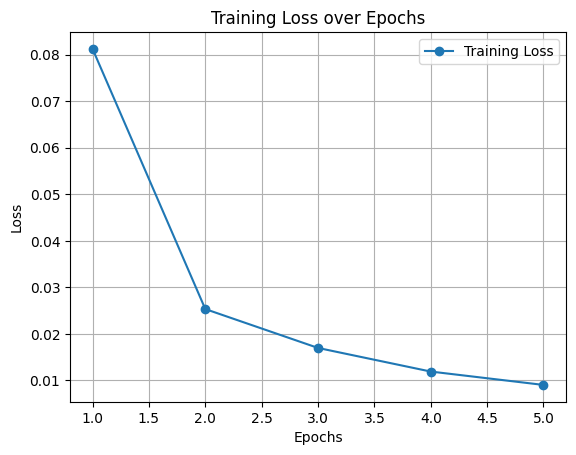

In [20]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label="Training Loss")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
list(label_map.keys())

['O',
 'B-treatment',
 'I-treatment',
 'B-chronic_disease',
 'I-chronic_disease',
 'B-cancer',
 'I-cancer',
 'B-allergy_name',
 'I-allergy_name']

In [22]:
from sklearn.metrics import f1_score
import numpy as np
from seqeval.metrics import classification_report

def evaluation(test_dataloaders, model):

    # Evaluation on test dataset
    model.eval()

    correct_predictions = 0
    total = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in tqdm.tqdm(test_dataloaders):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            # Get predictions by taking the argmax of the logits
            predictions = torch.argmax(outputs.logits, dim=-1)

            # Convert to numpy arrays
            labels = labels.cpu().numpy()
            predictions = predictions.cpu().numpy()

#             print("labels: ", labels.shape)
#             print("predictions: ", predictions.shape)

#             print("labels: ", labels)
#             print("predictions: ", predictions)
#             return

            for label, pred in zip(labels, predictions):
                # Filter out -100 labels
                y_true.append([id2label[l] for l in label if l != -100])
                y_pred.append([id2label[p] for p, l in zip(pred, label) if l != -100])

    print(classification_report(y_true, y_pred))
    print("*"*40)

#     print(y_true)
#     print(y_pred)

    report = classification_report(y_true, y_pred, output_dict=True)

    # Extracting F1 scores for each entity type
    entity_f1_scores = {}
    for label in ['treatment', 'chronic_disease', 'cancer', 'allergy_name']:
        entity_f1_scores[label] = report[label]['f1-score']

    weighted_avg_f1 = report['weighted avg']['f1-score']

    print("Entity-wise F1 scores:")
    for entity, score in entity_f1_scores.items():
        print(f"{entity}: {score:.4f}")
    print(f"Weighted Average F1 score: {weighted_avg_f1:.4f}")

    return (entity_f1_scores, weighted_avg_f1)

### Task 2

In [23]:
class EWC:
    def __init__(self, model, dataloader, importance=1000):
        self.model = model
        self.importance = importance
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._fishers = {}
        self.dataloader = dataloader
        self.compute_fisher_information()

    def compute_fisher_information(self):
        self.model.eval()
        fisher_diagonals = {n: torch.zeros_like(p) for n, p in self.params.items()}

        for batch in self.dataloader:
            outputs = self.model(input_ids=batch['input_ids'].to(device),
                                 attention_mask=batch['attention_mask'].to(device),
                                 labels=batch['labels'].to(device))
            loss = outputs.loss
            loss.backward()

            for n, p in self.params.items():
                fisher_diagonals[n] += (p.grad ** 2) / len(self.dataloader)

        for n, p in fisher_diagonals.items():
            self._fishers[n] = fisher_diagonals[n]
            self._means[n] = self.params[n].detach().clone()

    def penalty(self):
        loss = 0
        for n, p in self.params.items():
            fisher = self._fishers[n]
            mean = self._means[n]
            loss += (fisher * (p - mean) ** 2).sum()
        return loss * self.importance


In [24]:
import random
from torch.utils.data import Subset, ConcatDataset

# Keep 100 examples from T1
replay_buffer_T1 = random.sample(range(len(train_dataloaders["T1"].dataset)), 100)
sampled_dataset = Subset(train_dataloaders["T1"].dataset, replay_buffer_T1)
replay_dataloader_T1 = DataLoader(sampled_dataset, batch_size=batch_size, shuffle=True)

# Combine the two datasets
combined_dataset = ConcatDataset([train_dataloaders["T2"].dataset, replay_dataloader_T1.dataset])
# Create a new DataLoader from the combined dataset
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

# Task 2 training with EWC
print("Training on Task T2")

# model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_map))
# model.load_state_dict(torch.load('model_weights1.pth', weights_only=True))
# model.to(device)

# Elastic Weight Consolidation for Task 2
ewc_T2 = EWC(model, replay_dataloader_T1)

loss_values, model = train_model(model, train_dataloaders["T2"], optimizer, 'model_weights2.pth', ewc=ewc_T2, epochs=num_epochs)
# Assuming `model` is your trained model
# torch.save(multi_label_model.state_dict(), 'model_weights2.pth')

Training on Task T2


100%|██████████| 323/323 [03:50<00:00,  1.40it/s]


Epoch 1 - Loss: 0.029211484109146677
New minimum loss: 0.0292, saving model...


100%|██████████| 323/323 [03:50<00:00,  1.40it/s]


Epoch 2 - Loss: 0.018161326241693906
New minimum loss: 0.0182, saving model...


100%|██████████| 323/323 [03:50<00:00,  1.40it/s]


Epoch 3 - Loss: 0.012592665302918953
New minimum loss: 0.0126, saving model...


100%|██████████| 323/323 [03:50<00:00,  1.40it/s]


Epoch 4 - Loss: 0.008822424781664446
New minimum loss: 0.0088, saving model...


100%|██████████| 323/323 [03:51<00:00,  1.40it/s]


Epoch 5 - Loss: 0.006582645188127544
New minimum loss: 0.0066, saving model...


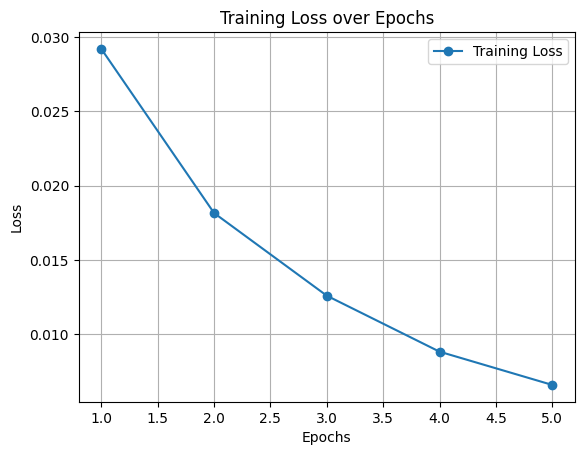

In [25]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label="Training Loss")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
from torch.utils.data import ConcatDataset

# Keep 100 examples from T1 and T2
replay_buffer_T1 = random.sample(range(len(train_dataloaders["T1"].dataset)), 100)
sampled_dataset1 = Subset(train_dataloaders["T1"].dataset, replay_buffer_T1)
replay_buffer_T2 = random.sample(range(len(train_dataloaders["T2"].dataset)), 100)
sampled_dataset2 = Subset(train_dataloaders["T2"].dataset, replay_buffer_T2)
combined_dataset = ConcatDataset([sampled_dataset1, sampled_dataset2])
replay_dataloader_T1_T2 = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

# Combine the two datasets
combined_dataset = ConcatDataset([train_dataloaders["T3"].dataset, replay_dataloader_T1_T2.dataset])
# Create a new DataLoader from the combined dataset
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

# Task 2 training with EWC
print("Training on Task T3")

# model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_map))
# model.load_state_dict(torch.load('model_weights2.pth', weights_only=True))
# model.to(device)

# Elastic Weight Consolidation for Task 1 and Task 2
ewc_T1_T2 = EWC(model, replay_dataloader_T1_T2)

loss_values, model = train_model(model, train_dataloaders["T3"], optimizer, 'model_weights3.pth', ewc=ewc_T1_T2, epochs=num_epochs)
# Assuming `model` is your trained model
# torch.save(multi_label_model.state_dict(), 'model_weights3.pth')

Training on Task T3


100%|██████████| 314/314 [03:44<00:00,  1.40it/s]


Epoch 1 - Loss: 0.028447151246367937
New minimum loss: 0.0284, saving model...


100%|██████████| 314/314 [03:44<00:00,  1.40it/s]


Epoch 2 - Loss: 0.017575527700020153
New minimum loss: 0.0176, saving model...


100%|██████████| 314/314 [03:44<00:00,  1.40it/s]


Epoch 3 - Loss: 0.012083320739785814
New minimum loss: 0.0121, saving model...


100%|██████████| 314/314 [03:44<00:00,  1.40it/s]


Epoch 4 - Loss: 0.008300796071079317
New minimum loss: 0.0083, saving model...


100%|██████████| 314/314 [03:44<00:00,  1.40it/s]


Epoch 5 - Loss: 0.00641057728663692
New minimum loss: 0.0064, saving model...


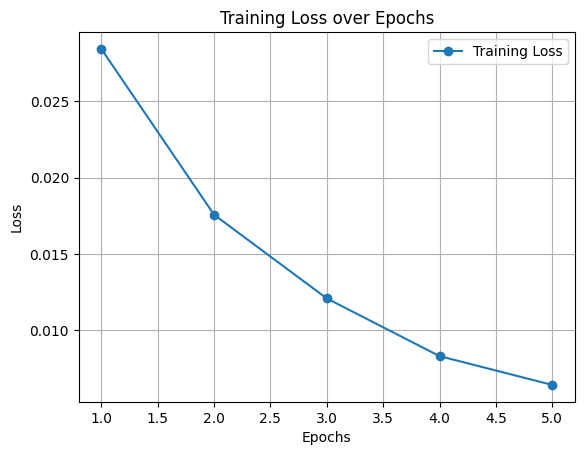

In [27]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label="Training Loss")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
#Training on complete G1+G2+G3
# Combine the datasets
combined_train_dataset = ConcatDataset([train_dataloaders["T1"].dataset, train_dataloaders["T2"].dataset, train_dataloaders["T3"].dataset])
combined_test_dataset = ConcatDataset([test_dataloaders["T1"].dataset, test_dataloaders["T2"].dataset, test_dataloaders["T3"].dataset])

# Create a new DataLoader from the combined dataset
combined_train_loader_123 = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
combined_test_loader_123 = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=True)

print("Training on G1+G2+G3 ")
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_map))# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_values, _ = train_model(model, combined_train_loader_123, optimizer, 'model_weights4.pth', epochs=num_epochs)

Training on G1+G2+G3 


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1004/1004 [11:25<00:00,  1.46it/s]


Epoch 1 - Loss: 0.049782790117470395
New minimum loss: 0.0498, saving model...


100%|██████████| 1004/1004 [11:25<00:00,  1.46it/s]


Epoch 2 - Loss: 0.021665205914653332
New minimum loss: 0.0217, saving model...


100%|██████████| 1004/1004 [11:25<00:00,  1.46it/s]


Epoch 3 - Loss: 0.016814892424921693
New minimum loss: 0.0168, saving model...


100%|██████████| 1004/1004 [11:26<00:00,  1.46it/s]


Epoch 4 - Loss: 0.012903303460684601
New minimum loss: 0.0129, saving model...


100%|██████████| 1004/1004 [11:27<00:00,  1.46it/s]


Epoch 5 - Loss: 0.010335032426728032
New minimum loss: 0.0103, saving model...


## Evaluation

In [29]:
## Task 1
print("Task 1")

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_map))
model.load_state_dict(torch.load('model_weights1.pth', weights_only=True))
model.to(device)

T1_results = evaluation(test_dataloaders['T1'], model)

Task 1


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 92/92 [00:19<00:00,  4.68it/s]


                 precision    recall  f1-score   support

   allergy_name       0.06      0.02      0.03        51
         cancer       0.56      0.59      0.58       387
chronic_disease       0.52      0.42      0.47      1118
      treatment       0.49      0.60      0.54      1248

      micro avg       0.51      0.51      0.51      2804
      macro avg       0.41      0.41      0.40      2804
   weighted avg       0.51      0.51      0.51      2804

****************************************
Entity-wise F1 scores:
treatment: 0.5415
chronic_disease: 0.4657
cancer: 0.5765
allergy_name: 0.0299
Weighted Average F1 score: 0.5068


In [30]:
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_map))
model.load_state_dict(torch.load('model_weights2.pth', weights_only=True))
model.to(device)

# Combine the two datasets
combined_dataset = ConcatDataset([test_dataloaders["T1"].dataset, test_dataloaders["T2"].dataset])
# Create a new DataLoader from the combined dataset
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

## Task 1
print("Task 1, 2")
T2_results = evaluation(combined_loader, model)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Task 1, 2


100%|██████████| 173/173 [00:36<00:00,  4.76it/s]


                 precision    recall  f1-score   support

   allergy_name       0.49      0.45      0.47       105
         cancer       0.59      0.58      0.59       759
chronic_disease       0.55      0.73      0.63      2207
      treatment       0.58      0.65      0.61      2391

      micro avg       0.57      0.67      0.62      5462
      macro avg       0.55      0.60      0.58      5462
   weighted avg       0.57      0.67      0.61      5462

****************************************
Entity-wise F1 scores:
treatment: 0.6140
chronic_disease: 0.6312
cancer: 0.5852
allergy_name: 0.4700
Weighted Average F1 score: 0.6142


In [31]:
## Task 3
print("Task 1, 2 and 3")

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_map))
model.load_state_dict(torch.load('model_weights3.pth', weights_only=True))
model.to(device)

T3_results = evaluation(combined_test_loader_123, model)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Task 1, 2 and 3


100%|██████████| 252/252 [00:51<00:00,  4.87it/s]


                 precision    recall  f1-score   support

   allergy_name       0.60      0.57      0.58       182
         cancer       0.62      0.60      0.61      1091
chronic_disease       0.61      0.62      0.61      3242
      treatment       0.56      0.71      0.63      3530

      micro avg       0.59      0.65      0.62      8045
      macro avg       0.60      0.62      0.61      8045
   weighted avg       0.59      0.65      0.62      8045

****************************************
Entity-wise F1 scores:
treatment: 0.6263
chronic_disease: 0.6110
cancer: 0.6101
allergy_name: 0.5803
Weighted Average F1 score: 0.6169


In [32]:
## Task 3
print("Task 4 - G1+G2+G3")

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(label_map))
model.load_state_dict(torch.load('model_weights4.pth', weights_only=True))
model.to(device)

T4_results = evaluation(combined_test_loader_123, model)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Task 4 - G1+G2+G3


100%|██████████| 252/252 [00:51<00:00,  4.93it/s]


                 precision    recall  f1-score   support

   allergy_name       0.46      0.34      0.39       182
         cancer       0.62      0.64      0.63      1091
chronic_disease       0.59      0.57      0.58      3242
      treatment       0.58      0.49      0.53      3530

      micro avg       0.59      0.54      0.56      8045
      macro avg       0.56      0.51      0.53      8045
   weighted avg       0.59      0.54      0.56      8045

****************************************
Entity-wise F1 scores:
treatment: 0.5326
chronic_disease: 0.5763
cancer: 0.6279
allergy_name: 0.3861
Weighted Average F1 score: 0.5598


In [33]:
def get_all_scores(results):
  score_dict = {'Weighted Average':[]}
  for result in results:
    for entity, score in result[0].items():
      score_dict[entity] = score_dict.get(entity,[])
      score_dict[entity].append(score)
    score_dict['Weighted Average'].append(result[1])
  score_df = pd.DataFrame(score_dict)
  return score_df

In [34]:
all_scores_df = get_all_scores([T1_results, T2_results, T3_results, T4_results]).T
all_scores_df.columns = ["Performance on the test set of T1","Performance on the test set of T1 and T2.","Performance on the test set of T1, T2 and T3.","Performance on combined G1+G2+G3"]
all_scores_df

Performance on the test set of T1  \
Weighted Average                           0.506789   
treatment                                  0.541501   
chronic_disease                            0.465672   
cancer                                     0.576485   
allergy_name                               0.029851   

                  Performance on the test set of T1 and T2.  \
Weighted Average                                   0.614178   
treatment                                          0.613997   
chronic_disease                                    0.631210   
cancer                                             0.585170   
allergy_name                                       0.470000   

                  Performance on the test set of T1, T2 and T3.  \
Weighted Average                                       0.616918   
treatment                                              0.626349   
chronic_disease                                        0.611009   
cancer                                                 0.610075   
allergy_name                                           0.580282   

                  Performance on combined G1+G2+G3  
Weighted Average                          0.559810  
treatment                                 0.532574  
chronic_disease                           0.576314  
cancer                                    0.627876  
allergy_name                              0.386076

In [35]:
all_scores_df.to_csv('all_scores_df.csv')